# 10.  Use transfer learning for large image classification

_Exercise: Use transfer learning for large image classification, going through these steps:_

* _Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets)._
* _Split it into a training set, a validation set, and a test set._
* _Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation._
* _Fine-tune a pretrained model on this dataset._

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2025-02-27 21:48:41.720177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740689321.738939  221078 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740689321.744695  221078 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 21:48:41.763009: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1740689325.993493  221078 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1


In [2]:
import tensorflow_datasets as tfds

from keras.api.layers import Conv2D, MaxPooling2D, InputLayer, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.api.models import Sequential, Model
# from keras.api.applications.xception import Xception, preprocess_input
from keras.api.applications.mobilenet import MobileNet, preprocess_input
from keras.api.optimizers import SGD, Nadam, Adam
from keras.api.optimizers.schedules import CosineDecayRestarts
from keras.api.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.api import layers
from keras.api.regularizers import l2
import keras

import collections

import numpy as np

import matplotlib.pyplot as plt

import datetime

from sklearn.model_selection import train_test_split

In [3]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

## Loading data

In [4]:
# ds, info = tfds.load(
#     "beans",
#     split=["train", "validation", "test"],
#     with_info=True,
#     shuffle_files=True,
#     as_supervised=True,
# )

# ds_train = ds[0]
# ds_valid = ds[1]
# ds_test = ds[2]

ds, info = tfds.load(
    "beans",
    split="all",
    with_info=True,
    shuffle_files=True,
    as_supervised=True,
)

n_classes = info.features["label"].num_classes
class_names = info.features["label"].names

# Same ratio as in original dataset
train_size = 1034
val_size = 133
test_size = 128

In [5]:
ds_pd = tfds.as_dataframe(ds, info)
ds_pd_images = ds_pd["image"]
ds_pd_labels = ds_pd["label"]

2025-02-27 21:48:48.002266: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-02-27 21:48:48.589334: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
ds_pd_images.shape

(1295,)

In [7]:
ds_pd_labels.shape

(1295,)

In [8]:
train_data, temp_data, train_labels, temp_labels = train_test_split(
    ds_pd_images,
    ds_pd_labels,
    train_size=train_size,
    random_state=42,
    shuffle=True,
    stratify=ds_pd_labels,
)

val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data,
    temp_labels,
    train_size=val_size,
    random_state=42,
    shuffle=True,
    stratify=temp_labels,
)

ds_train = tf.data.Dataset.from_tensor_slices((np.array(train_data.tolist()), np.array(train_labels.tolist())))
ds_valid = tf.data.Dataset.from_tensor_slices((np.array(val_data.tolist()), np.array(val_labels.tolist())))
ds_test = tf.data.Dataset.from_tensor_slices((np.array(test_data.tolist()), np.array(test_labels.tolist())))

In [9]:
print(len(list(ds_train)))
print(len(list(ds_valid)))
print(len(list(ds_test)))

1034
133
128


2025-02-27 21:48:51.109208: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-27 21:48:51.243462: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
info.description

'Beans is a dataset of images of beans taken in the field using smartphone\ncameras. It consists of 3 classes: 2 disease classes and the healthy class.\nDiseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by\nexperts from the National Crops Resources Research Institute (NaCRRI) in Uganda\nand collected by the Makerere AI research lab.'

In [11]:
ds_train

<_TensorSliceDataset element_spec=(TensorSpec(shape=(500, 500, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
for image, label in ds_train.take(2):
  print(image.shape, label)

(500, 500, 3) tf.Tensor(2, shape=(), dtype=int64)
(500, 500, 3) tf.Tensor(0, shape=(), dtype=int64)


In [13]:
def count_labels(dataset):
    label_counts = collections.Counter()

    for _, label in dataset:
        label_counts[label.numpy()] += 1

    total_count = sum(label_counts.values())
    label_ratios = {label: count / total_count for label, count in label_counts.items()}
    
    sorted_label_ratios = dict(sorted(label_ratios.items()))

    return sorted_label_ratios

In [14]:
# Make sure that ratio of different classes is same across datasets

print(count_labels(ds_train))
print(count_labels(ds_valid))
print(count_labels(ds_test))

{0: 0.33365570599613154, 1: 0.3365570599613153, 2: 0.32978723404255317}
{0: 0.3308270676691729, 1: 0.3383458646616541, 2: 0.3308270676691729}
{0: 0.3359375, 1: 0.3359375, 2: 0.328125}


2025-02-27 21:48:51.647742: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Preprocess and Augmentation

In [ ]:
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(preprocess_input)
])

preprocess_and_augmentation = tf.keras.Sequential([
    layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(factor=(-0.2, 0.2)),
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    # layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)), 
    layers.RandomContrast(factor=0.2),
    layers.RandomBrightness(factor=(-0.2, 0.2)),
    layers.GaussianNoise(stddev=0.05),
    layers.Lambda(preprocess_input)
])

In [16]:
ds_train = ds_train.map(
    lambda X, y: (preprocess_and_augmentation(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [17]:
ds_valid = ds_valid.map(
    lambda X, y: (preprocess(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.cache()
ds_valid = ds_valid.batch(batch_size)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

In [18]:
ds_test = ds_test.map(
    lambda X, y: (preprocess(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

2025-02-27 21:48:52.307022: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_10}}
2025-02-27 21:49:02.319109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 652 of 1034
2025-02-27 21:49:08.102637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


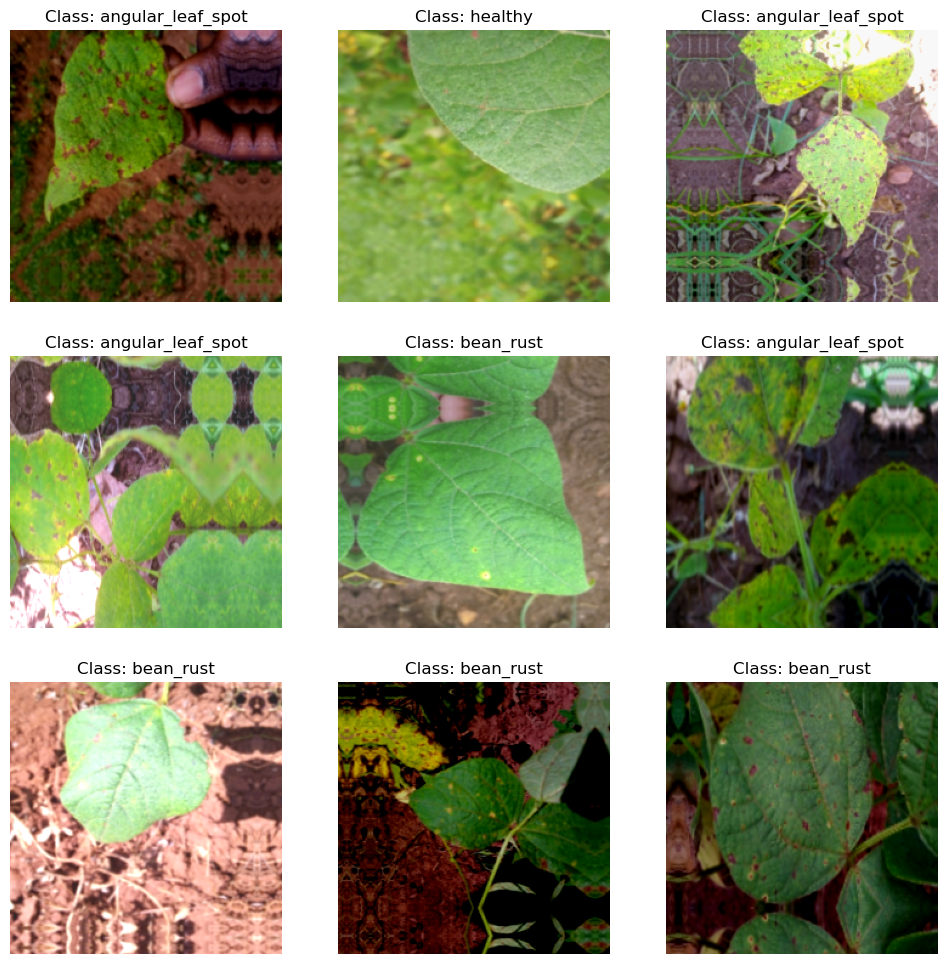

In [19]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in ds_train.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

## Base model with pre-trained weights

In [20]:
tf.keras.backend.clear_session()

In [21]:
base_model = MobileNet(weights="imagenet", include_top=False, dropout=0.1)
avg = GlobalAveragePooling2D()(base_model.output)
batch_norm = BatchNormalization()(avg)
dropout = Dropout(0.6)(batch_norm)
output = Dense(n_classes, activation="softmax", kernel_regularizer=l2(0.01))(dropout)
model = Model(inputs=base_model.input, outputs=output)
model.summary()

/tmp/ipykernel_221078/2641699572.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights="imagenet", include_top=False, dropout=0.1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, None, None, 32) │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, None, None, 32) │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, None, None, 32) │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, None, None, 64) │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, None, None, 64) │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, None, None,     │         8,192 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, None, None,     │         1,152 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,236,035 (12.34 MB)

 Trainable params: 3,212,099 (12.25 MB)

 Non-trainable params: 23,936 (93.50 KB)

In [22]:
for layer in base_model.layers:
    layer.trainable = False

In [23]:
initial_learning_rate = 0.001  # Slightly increased learning rate
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=10,  # Adjusted steps
    t_mul=2.0,
    m_mul=0.9,
    alpha=0.0001,  # Adjusted minimum lr
)

In [24]:
def one_cycle_scheduler(epoch, lr):
    max_lr = 0.0005 # Reduced max learning rate
    epochs = 100
    if epoch < epochs * 0.4:
        return max_lr * epoch / (epochs * 0.4)
    else:
        return max_lr * (1 + np.cos(np.pi * (epoch - epochs * 0.4) / (epochs * 0.6))) / 2

lr_callback = LearningRateScheduler(one_cycle_scheduler)

In [25]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode="min")
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

## Initial training without touching base model

In [26]:
optimizer = Nadam(learning_rate=1e-4)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=100,
    callbacks=[early_stopping, lr_callback],
)

Epoch 1/100


2025-02-27 21:49:11.030548: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_10}}
I0000 00:00:1740689354.002088  221163 service.cc:148] XLA service 0x7f283400dbd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740689354.002144  221163 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-0

33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 283ms/step - accuracy: 0.3324 - loss: 2.2920 - val_accuracy: 0.3158 - val_loss: 1.7414 - learning_rate: 0.0000e+00
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.3177 - loss: 2.2556 - val_accuracy: 0.3308 - val_loss: 1.7066 - learning_rate: 1.2500e-05
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.3295 - loss: 2.2780 - val_accuracy: 0.3534 - val_loss: 1.6558 - learning_rate: 2.5000e-05
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.3428 - loss: 2.1505 - val_accuracy: 0.3609 - val_loss: 1.5969 - learning_rate: 3.7500e-05
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.3670 - loss: 1.9725 - val_accuracy: 0.3910 - val_loss: 1.5190 - learning_rate: 5.0000e-05
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.3455 - loss: 2.0018 - val_accuracy: 0.4211 - val_loss: 1.4274 - learning_rate: 6.2500e-05
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.41

In [27]:
early_stopping.best_epoch

50

4/4 - 0s - 118ms/step - accuracy: 0.8750 - loss: 0.3909
0.875


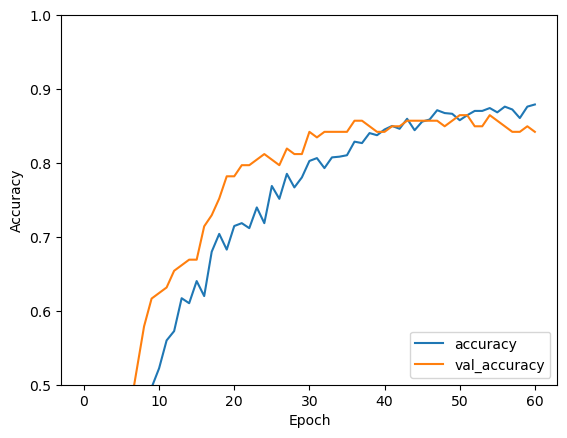

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(test_acc)

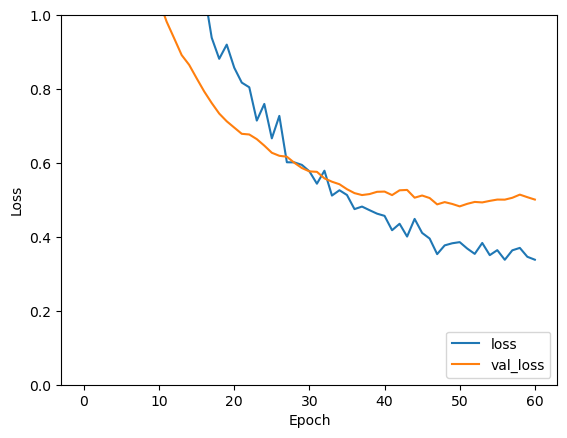

In [29]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

## Fine tuning

In [30]:
len(base_model.layers)

86

In [31]:
# Callbacks (repeating here because EarlyStopping stopped too early second time - better restart it)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode="min")
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [32]:
# TensorBoard Callback (repeating here to have unique timestamp)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [33]:
# Fine tuning learning rate scheduler
def fine_tune_lr_scheduler(epoch, lr):
    initial_lr = 1e-5
    decay_rate = 0.95
    return initial_lr * (decay_rate ** epoch)

fine_tune_lr_callback = LearningRateScheduler(fine_tune_lr_scheduler)

In [34]:
for layer in base_model.layers[-42:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True  # Unfreeze the top layers while leaving BatchNorm layers frozen.

optimizer = Nadam(learning_rate=1e-5)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=100,
    callbacks=[early_stopping, tensorboard_callback, fine_tune_lr_callback],
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 432ms/step - accuracy: 0.8893 - loss: 0.3113 - val_accuracy: 0.8571 - val_loss: 0.5345 - learning_rate: 1.0000e-05
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.8963 - loss: 0.3199 - val_accuracy: 0.8797 - val_loss: 0.4260 - learning_rate: 9.5000e-06
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.8977 - loss: 0.2906 - val_accuracy: 0.8797 - val_loss: 0.4255 - learning_rate: 9.0250e-06
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.9379 - loss: 0.2274 - val_accuracy: 0.8722 - val_loss: 0.4676 - learning_rate: 8.5738e-06
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.9296 - loss: 0.2190 - val_accuracy: 0.8797 - val_loss: 0.4505 - learning_rate: 8.1451e-06
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.9463 - loss: 0.1975 - val_accuracy: 0.8797 - val_loss: 0.4291 - learning_rate: 7.7378e-06
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - ac

In [35]:
early_stopping.best_epoch

2

In [36]:
val_loss, val_acc = model.evaluate(ds_valid, verbose=2)
print(val_acc)

5/5 - 0s - 87ms/step - accuracy: 0.8797 - loss: 0.4255
0.8796992301940918


In [37]:
train_loss, train_acc = model.evaluate(ds_train, verbose=2)
print(train_acc)

33/33 - 4s - 124ms/step - accuracy: 0.9787 - loss: 0.1321
0.978723406791687


4/4 - 0s - 93ms/step - accuracy: 0.8906 - loss: 0.3255
0.890625


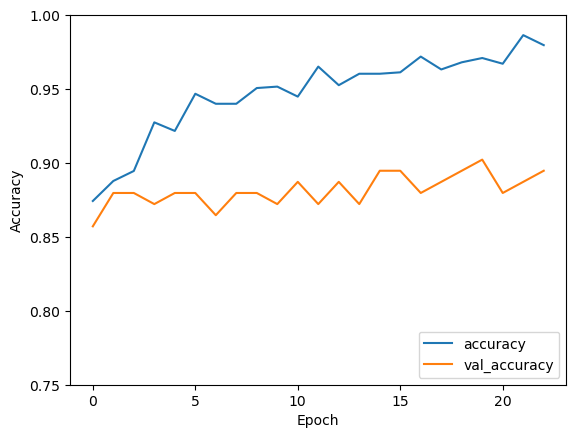

In [38]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.75, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(test_acc)

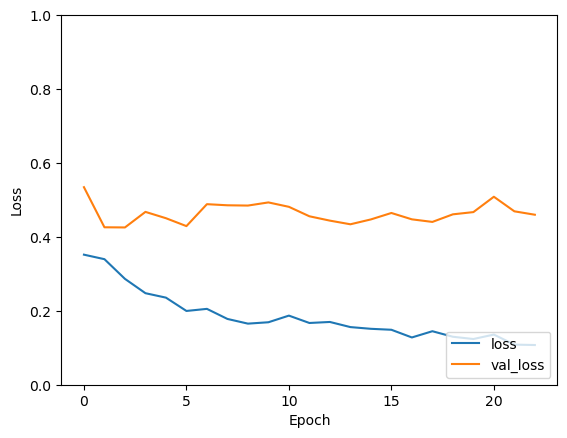

In [39]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

- accuracy without data augmentation or dropout: train: 1.00, validation: 0.9323, test: 0.9062
- accuracy with data augmentation but without dropout: train: 1.00, validation: 0.9549, test: 0.9062
- accuracy with data augmentation and dropout (0.25) : train: 0.9993, validation: 0.9549, test: 0.9453 